In [ ]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.integrate as integrate
from tqdm.auto import tqdm

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
plt.style.use("default")
plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "figure.facecolor": "white",
    }
)

n_dense_points = 201

In [ ]:
class MLP(nn.Module):
    def __init__(self, *features, activation=nn.Tanh):
        super().__init__()

        layers = []
        for in_features, out_features in zip(features, features[1:]):
            layers.append(nn.Linear(in_features, out_features))
            layers.append(activation())
        self.network = nn.Sequential(*layers[:-1])

    def forward(self, x):
        return self.network(x)

In [ ]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]

$$
-y''+xy'+cy=((-2L+2)+(4+cL)x+(L-c-1)x^2-x^3)e^x\\
y(0)=0, \quad y(1)=0
$$

In [ ]:
c=10

In [ ]:
torch.manual_seed(78)
model = MLP(1, 16, 32, 1)
domain=(0,1)

PINN1

In [ ]:
batch_size = 10000
n_epochs = 1000
print_interval = n_epochs // 10
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.98 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)


loss_history = []
realloss_history_o=[]
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    # 무작위 t 생성 후 y 계산
    t = torch.empty(batch_size, 1).uniform_(*domain).requires_grad_()
    y = model(t)
    y_e=t*(L-t)*torch.exp(t)
    y_t = grad(y, t)
    y_tt = grad(y_t,t)

    # Loss
    loss_de = F.mse_loss(y_tt-t*y_t-c*y+((4+c)*t+(-c)*t**2-t**3)*(torch.exp(t)), torch.zeros_like(y_t))
    loss_ic1 = F.mse_loss(model(torch.tensor([[0]])), torch.tensor([[0]]))
    loss_ic2 = F.mse_loss(model(torch.tensor([[1]])), torch.tensor([[0]]))
    loss_ic = loss_ic1 + loss_ic2
    loss = loss_de + loss_ic
    realloss=F.mse_loss(y-y_e, torch.zeros_like(y))
    # Backprop
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.item())
    realloss_history_o.append(realloss.item())
    if epoch % print_interval == 0:
        print(f"{epoch = }, loss_de = {loss_de.item():.4f}, loss_ic = {loss_ic.item():.4f}, loss = {loss.item():.4f}")


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch = 0, loss_de = 15.7228, loss_ic = 0.1858, loss = 15.9087
epoch = 100, loss_de = 0.1387, loss_ic = 0.6986, loss = 0.8373
epoch = 200, loss_de = 0.1082, loss_ic = 0.6767, loss = 0.7849
epoch = 300, loss_de = 0.1013, loss_ic = 0.6727, loss = 0.7740
epoch = 400, loss_de = 0.1020, loss_ic = 0.6721, loss = 0.7742
epoch = 500, loss_de = 0.1018, loss_ic = 0.6720, loss = 0.7738
epoch = 600, loss_de = 0.0991, loss_ic = 0.6720, loss = 0.7711
epoch = 700, loss_de = 0.1000, loss_ic = 0.6720, loss = 0.7720
epoch = 800, loss_de = 0.1024, loss_ic = 0.6720, loss = 0.7744
epoch = 900, loss_de = 0.1006, loss_ic = 0.6720, loss = 0.7727


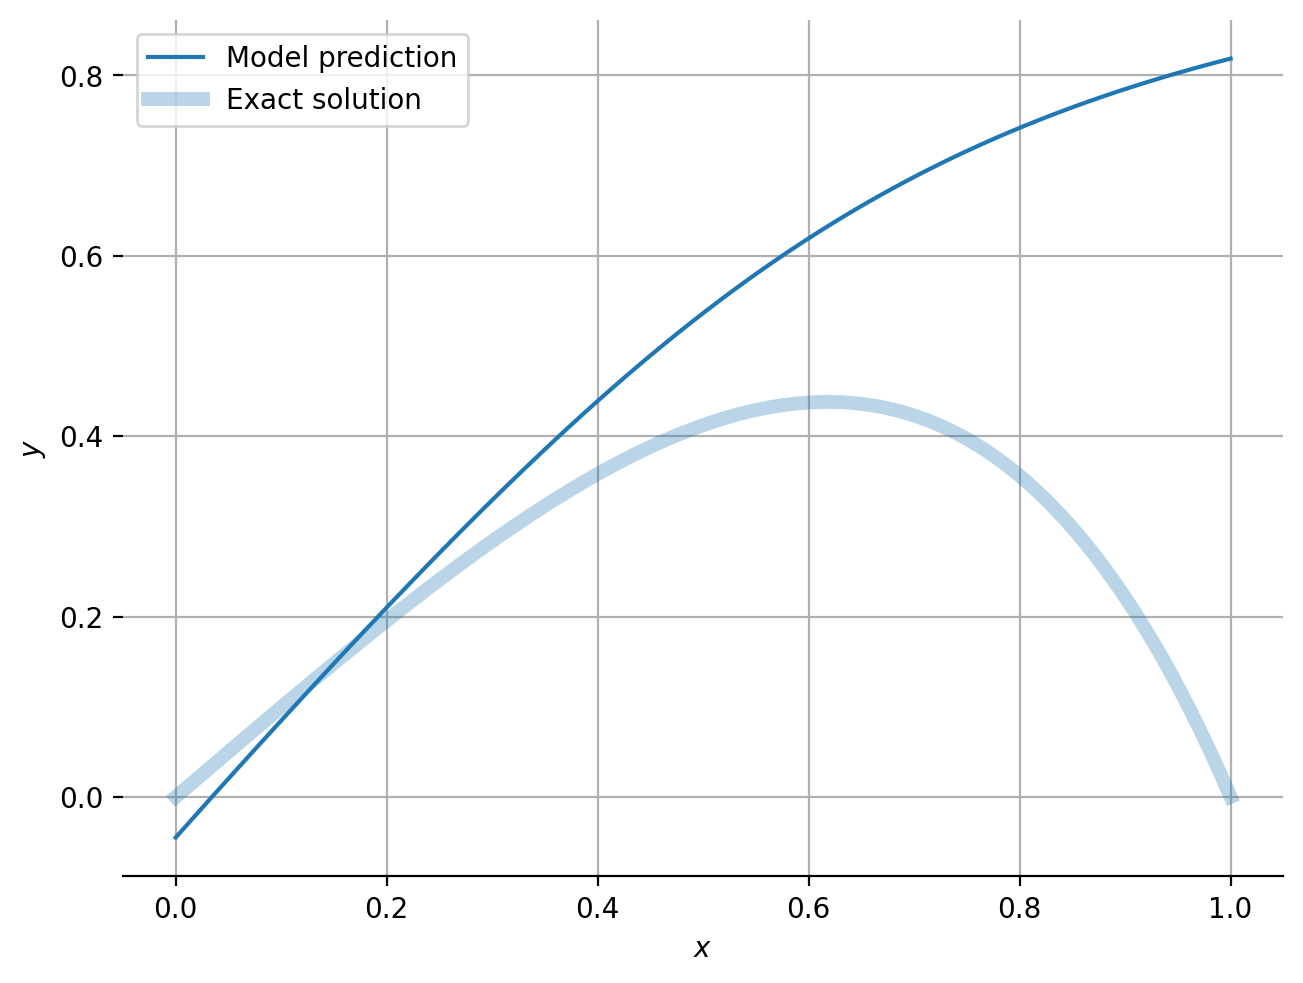

In [ ]:
t_dense=np.linspace(*domain,n_dense_points)
t = torch.tensor(t_dense, dtype=torch.float32).unsqueeze(-1)
with torch.no_grad():
    y = model(t)
with torch.no_grad():
    y_e = t*(1-t)*torch.exp(t)
fig, ax = plt.subplots()
ax.plot(t, y, c="C0", label="Model prediction")
ax.plot(
    t_dense,
    y_e,
    c="C0",
    linewidth=5,
    alpha=0.3,
    label="Exact solution",
)
ax.set(
    xlabel=r"$x$",
    ylabel=r"$y$"
)
ax.grid()
ax.legend()
ax.spines[["top", "right", "left"]].set_visible(False)
pass

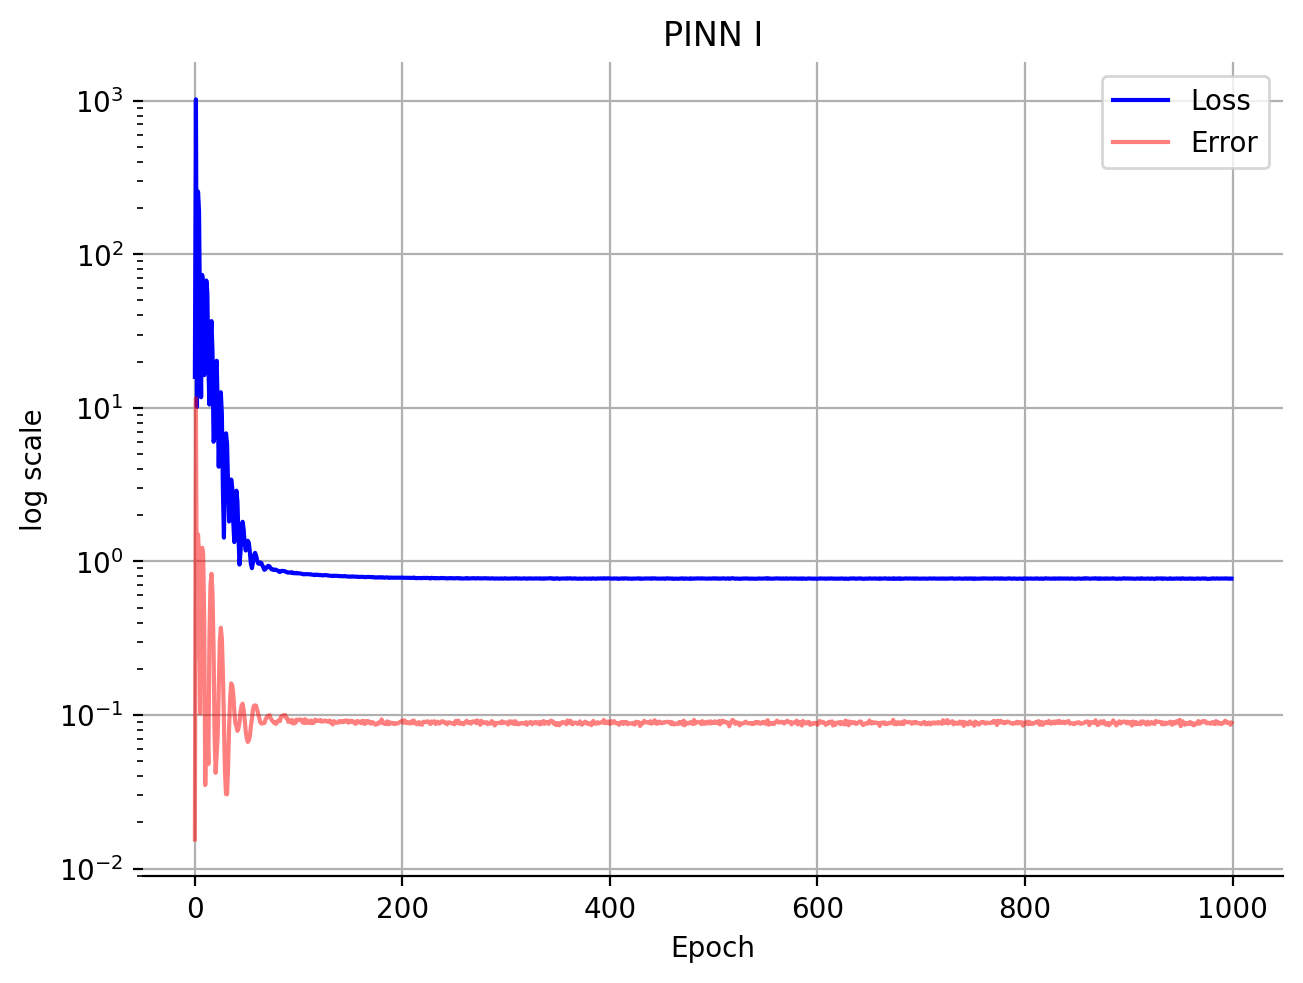

In [ ]:
fig, ax = plt.subplots()
ax.plot(loss_history,"b", label = "Loss")
ax.plot(realloss_history_o,"r",alpha=0.5, label = "Error")
ax.set(
    yscale="log",
    xlabel="Epoch",
    ylabel="log scale",
    title = "PINN I"
)
ax.legend()
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass


PINN2

In [ ]:
c=10

In [ ]:
torch.manual_seed(78)
model = MLP(1, 16, 32, 1)
batch_size = 10000
n_epochs = 500
print_interval = n_epochs // 10
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.98 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

loss_history = []
realloss_history_o=[]
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    # 무작위 t 생성 후 y 계산
    t = torch.empty(batch_size, 1).uniform_(*domain).requires_grad_()
    y = t*(1-t)*model(t)
    y_e=t*(1-t)*torch.exp(t)
    y_t = grad(y, t)
    y_tt = grad(y_t,t)

    # Loss
    loss_de = F.mse_loss(y_tt-t*y_t-c*y+((4+c)*t+(-c)*t**2-t**3)*(torch.exp(t)), torch.zeros_like(y_t))
    loss = loss_de
    realloss=F.mse_loss(y-y_e, torch.zeros_like(y))
    # Backprop
    loss.backward()
    optimizer.step()
    scheduler.step()
    loss_history.append(loss.item())
    realloss_history_o.append(realloss.item())
    if epoch % print_interval == 0:
        print(f"{epoch = }, loss_de = {loss_de.item():.4f}")


  0%|          | 0/500 [00:00<?, ?it/s]

epoch = 0, loss_de = 34.4366
epoch = 50, loss_de = 0.1223
epoch = 100, loss_de = 0.0169
epoch = 150, loss_de = 0.0124
epoch = 200, loss_de = 0.0107
epoch = 250, loss_de = 0.0099
epoch = 300, loss_de = 0.0102
epoch = 350, loss_de = 0.0096
epoch = 400, loss_de = 0.0097
epoch = 450, loss_de = 0.0098


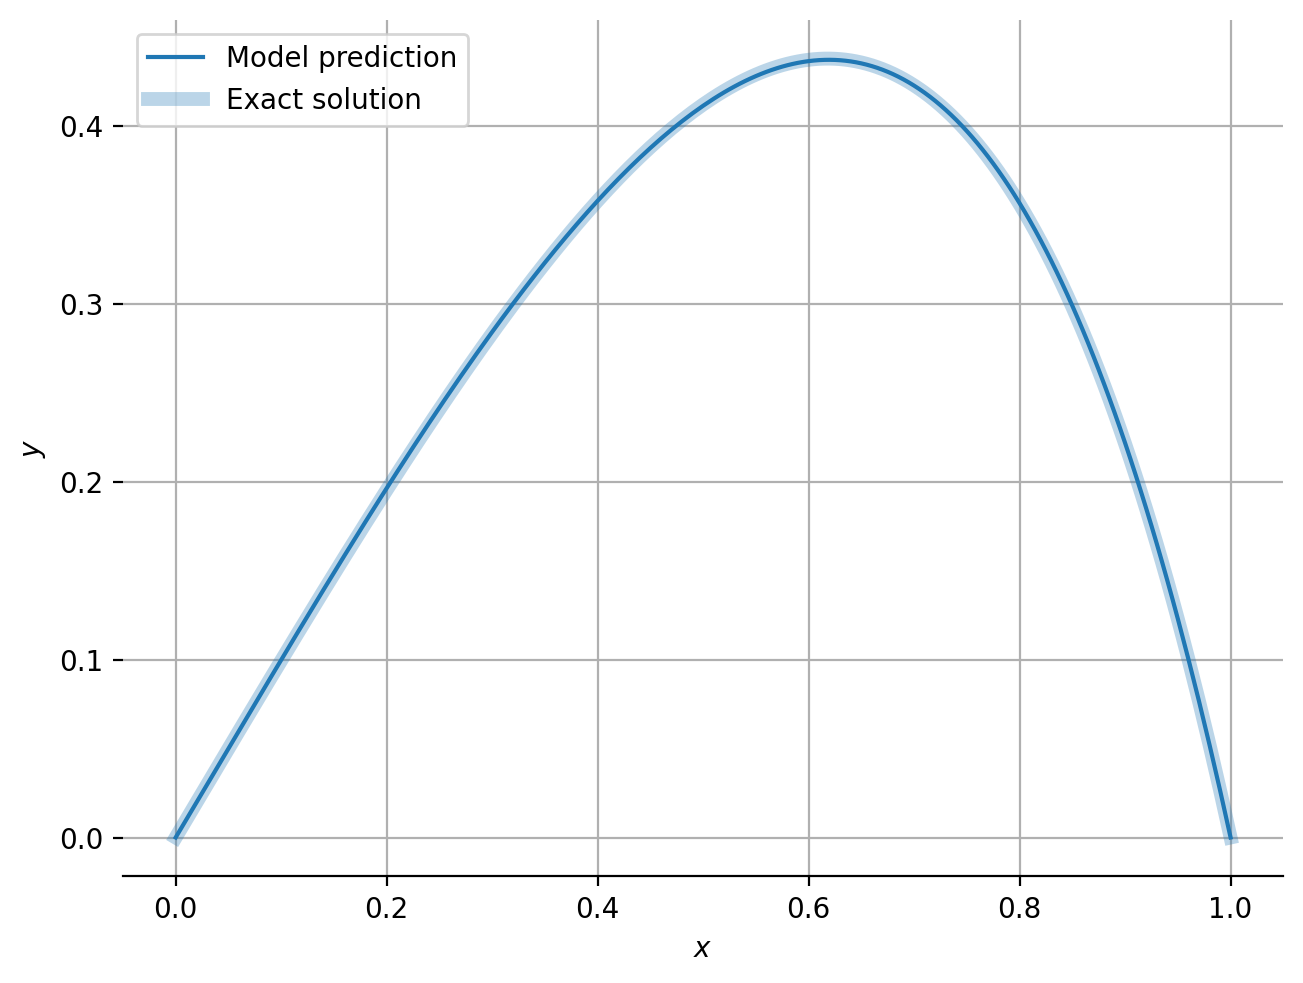

In [ ]:
t_dense=np.linspace(*domain,n_dense_points)
t = torch.tensor(t_dense, dtype=torch.float32).unsqueeze(-1)
with torch.no_grad():
    y = t*(1-t)*model(t)
with torch.no_grad():
    y_e = t*(1-t)*torch.exp(t)
fig, ax = plt.subplots()
ax.plot(t, y, c="C0", label="Model prediction")
ax.plot(
    t_dense,
    y_e,
    c="C0",
    linewidth=5,
    alpha=0.3,
    label="Exact solution",
)
ax.set(
    xlabel=r"$x$",
    ylabel=r"$y$"
)
ax.grid()
ax.legend()
ax.spines[["top", "right", "left"]].set_visible(False)
pass

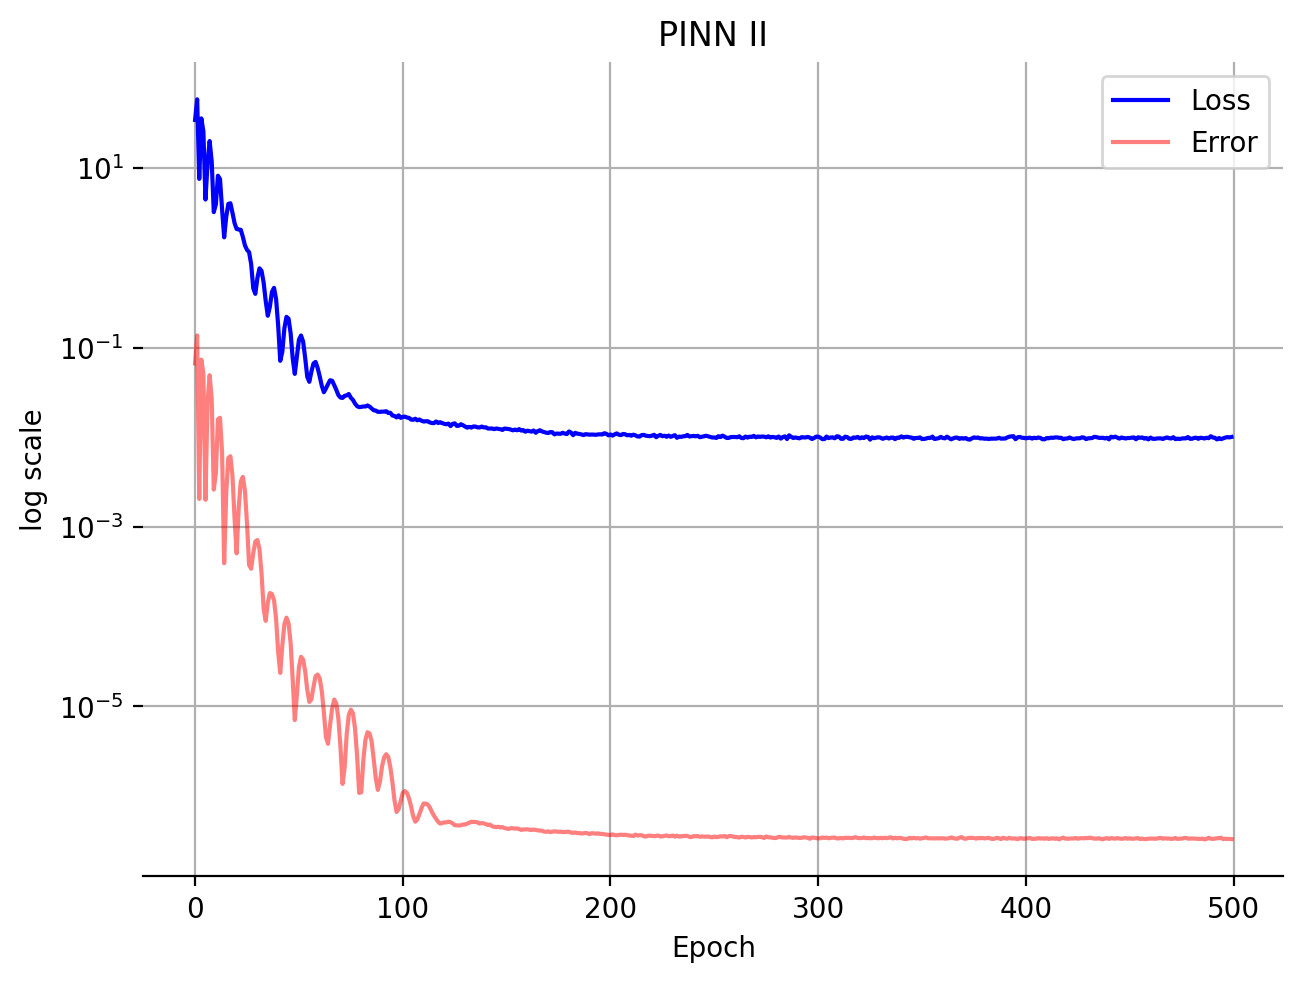

In [ ]:
fig, ax = plt.subplots()
ax.plot(loss_history,"b", label = "Loss")
ax.plot(realloss_history_o,"r",alpha=0.5, label = "Error")
ax.set(
    yscale="log",
    xlabel="Epoch",
    ylabel="log scale",
    title = "PINN II"
)
ax.legend()
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass
